[*********************100%***********************]  1 of 1 completed

Epoch 1/100



C:\Users\sagor\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0108
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 5.3698e-04
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 4.4216e-04
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 3.6443e-04
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 4.5446e-04
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 2.9997e-04
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 3.6296e-04
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 3.1739e-04
Epoch 9/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 3.2060e-04
Epoch 10/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 3.5654e-04
Epoch 11/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 3.2044e-04
Epoch 12/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 3.0116e-04
Epoch 13/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 3.1058e-04
Epoch 14/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 2.9593e-04
Epoch 15/100
73/7

C:\Users\sagor\AppData\Local\Temp\ipykernel_24120\2735529090.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


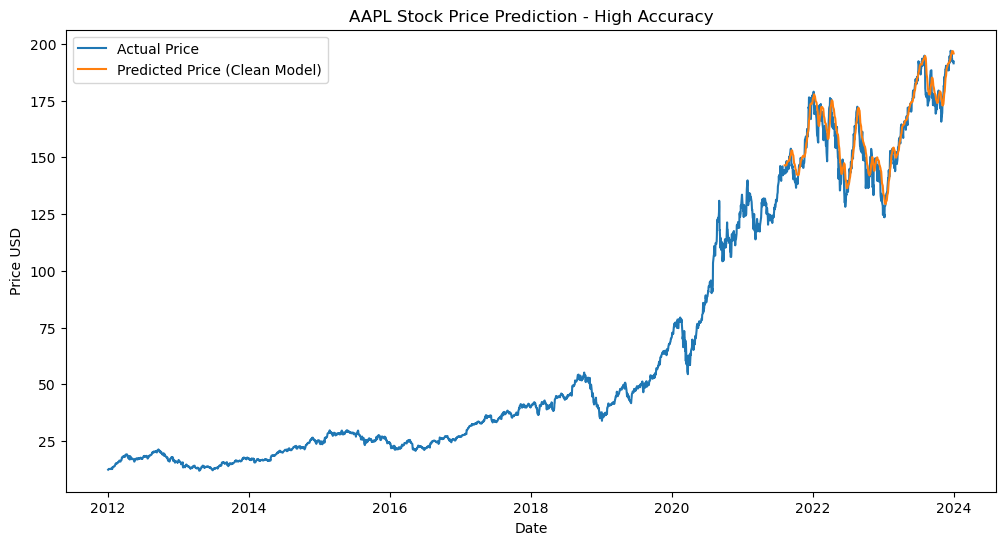

In [6]:
# Install requirements
!pip install yfinance scikit-learn tensorflow --quiet

# Import
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load data
df = yf.download('AAPL', start='2012-01-01', end='2024-01-01')
data = df[['Close']].values

# Normalize 0 to 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
seq_len = 90
train_len = int(len(scaled_data) * 0.8)

X, y = [], []
for i in range(seq_len, train_len):
    X.append(scaled_data[i-seq_len:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build better model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.0003), loss='mean_squared_error')
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train
model.fit(X, y, epochs=100, batch_size=32, callbacks=[early_stop])

# Test data
test_data = scaled_data[train_len - seq_len:]
X_test = []
y_test_actual = data[train_len:, :]
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Evaluate
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
r2 = r2_score(y_test_actual, predictions)

print(f"📈 Mean Absolute Error (MAE): {mae:.2f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"✅ R² Score: {r2:.4f}")

# Visual
valid = df[train_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Actual Price')
plt.plot(valid['Predictions'], label='Predicted Price (Clean Model)')
plt.title('AAPL Stock Price Prediction - High Accuracy')
plt.xlabel('Date')
plt.ylabel('Price USD')
plt.legend()
plt.show()
